In [101]:
import sys
import pandas as pd
import os
import numpy as np
pd.options.display.max_columns = 50

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import openmatrix as omx

import statsmodels.api as sm 
from statsmodels.formula.api import ols 
import statsmodels.formula.api as smf

ASIM_OUTPUT = r"E:\Met_Council\metc-asim-model\Base_2018\activitysim\output"
ASIM_CONFIGS_PATH = r'E:\Met_Council\metc-asim-model\source\activitysim\configs'
SURVEY_SUMMARY_PATH = r'E:\Met_Council\metc-asim-model\Input\Visualizer\base'
SYNPOP_INPUT = r'E:\Met_Council\metc-asim-model\Input\socioeconomic'
SURVEY_PATH = r'E:\Met_Council\survey_data\Phase2\SPA_Inputs'
CENSUS_SUMMARY_PATH = r'E:\Met_Council\metc-asim-model\Input\Visualizer\census'
SKIM_PATH = r'E:\Met_Council\metc-asim-model\Base_2018\OMX\allskims.omx'
SKIM_TABLE = 'DIST'

PERTYPEMAP = {1: 'FT', 2: 'PT', 3: 'U', 4: 'NW', 5: 'R', 6: 'SD', 7: 'SPD', 8: 'PS'}

TourCompMap = {'All Adult': 'adults', 'All Children': 'children', 'Mixed': 'mixed'}

coef_map = {'adults': 'coef_asc_adults', 'children': 'coef_asc_children', 'mixed': 'coef_asc_mixed'}

DISC_PURPS = ['social', 'eatout', 'othdiscr']

hh = pd.read_csv(os.path.join(ASIM_OUTPUT, "final_households.csv")).set_index('household_id')
tours = pd.read_csv(os.path.join(ASIM_OUTPUT, "final_tours.csv")).set_index('tour_id')

obs_joint_tour_len = pd.read_csv(os.path.join(SURVEY_SUMMARY_PATH, "tourDistProfile_vis.csv")) #.rename(columns = {'freq': 'ObsN'})

omx_file = omx.open_file(SKIM_PATH, 'r')
dist_skim = np.array(omx_file[SKIM_TABLE])
omx_file.close()

joint_tours = tours[tours['tour_category'] == 'joint'].copy()
joint_tours['PURPOSE'] = 'jmain'
joint_tours.loc[joint_tours['tour_type'].isin(DISC_PURPS), 'PURPOSE'] = 'jdisc'
joint_tours['distance'] = ((dist_skim[joint_tours['origin'].astype(int) - 1, joint_tours['destination'].astype(int) - 1]).astype(int) + 1).clip(0, 41)
model_tour_len_freq = joint_tours.groupby(['PURPOSE', 'distance']).agg(freq = ('person_id', 'count')).reset_index()


C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_15344\3522996121.py:35: DtypeWarning: Columns (16,18,19,20,28) have mixed types. Specify dtype option on import or set low_memory=False.
  tours = pd.read_csv(os.path.join(ASIM_OUTPUT, "final_tours.csv")).set_index('tour_id')


# Summary Output

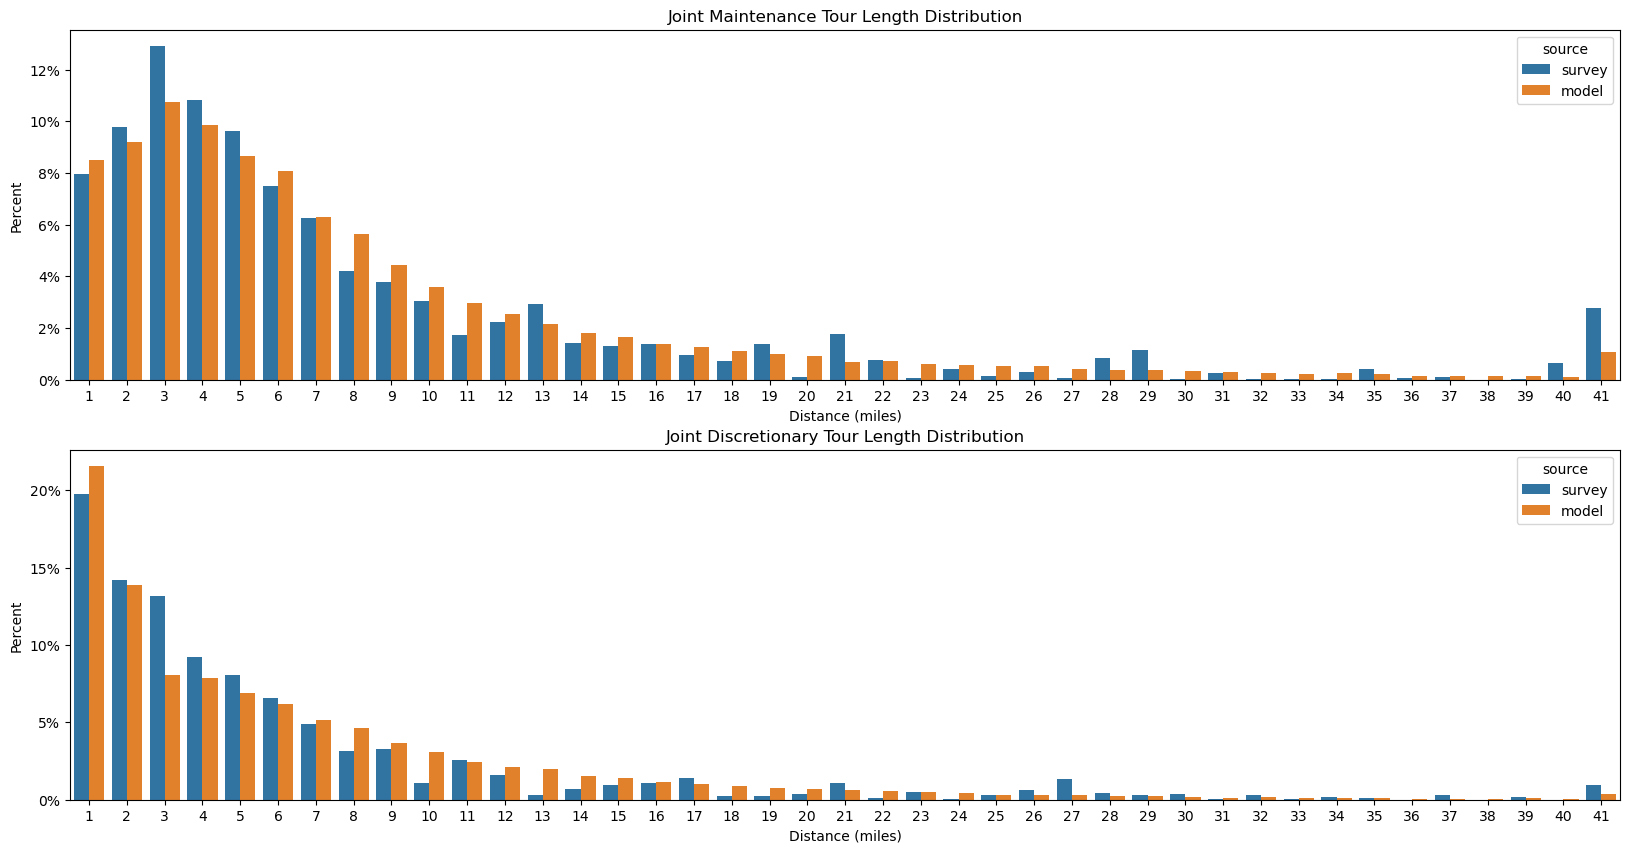

In [102]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
plot_idx = 210
count = 1
purp_labels = {'jmain': 'Joint Maintenance', 'jdisc': 'Joint Discretionary'}
for purp in ['jmain', 'jdisc']:
    plot_data = pd.concat([obs_joint_tour_len[obs_joint_tour_len['PURPOSE'] == purp].rename(columns = {'distbin': 'distance'}).assign(percent = lambda x: x['freq'] / x['freq'].sum(), source = 'survey'),
        model_tour_len_freq[model_tour_len_freq['PURPOSE'] == purp].assign(percent = lambda x: x['freq'] / x['freq'].sum(), source = 'model')])
    plot_data['distance'] = plot_data['distance'] 
    ax = plt.subplot(plot_idx + count)
    sns.barplot(data = plot_data, x = 'distance', y = 'percent', hue = 'source')
    plt.title(f"{purp_labels[purp]} Tour Length Distribution")
    # plt.xticks(fontsize=16, rotation = 90)
    # plt.yticks(fontsize=16)
    plt.ylabel('Percent')
    plt.xlabel('Distance (miles)')
    ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0%}'))
    count += 1

In [103]:
for purp in ['jmain', 'jdisc']:
    x = obs_joint_tour_len[obs_joint_tour_len['PURPOSE'] == purp].rename(columns = {'distbin': 'distance'}).assign(percent = lambda x: x['freq'] / x['freq'].sum())
    y = model_tour_len_freq[model_tour_len_freq['PURPOSE'] == purp].assign(percent = lambda x: x['freq'] / x['freq'].sum())
    cr = x[['distance', 'percent']].set_index('distance').join(y[['distance', 'percent']].set_index('distance'), lsuffix = '_x', rsuffix = '_y').min(1).sum() / x[['distance', 'percent']].set_index('distance').join(y[['distance', 'percent']].set_index('distance'), lsuffix = '_x', rsuffix = '_y').max(1).sum()
    print(f"Purpose: {purp}, obs ATF: {np.average(x.distance, weights = x.freq):0.2f}, mod ATF: {np.average(y.distance, weights = y.freq):0.2f}, coincidence ratio = {cr:0.2f}")


Purpose: jmain, obs ATF: 8.56, mod ATF: 8.37, coincidence ratio = 0.81
Purpose: jdisc, obs ATF: 6.45, mod ATF: 6.53, coincidence ratio = 0.79


# Adjust Joint Maintenance Tours

In [104]:
# Maint adjustments
purp = 'jmain'
adjust_data = pd.concat([obs_joint_tour_len[(obs_joint_tour_len['PURPOSE'] == purp) & (obs_joint_tour_len['distbin'] > 0) & (obs_joint_tour_len['distbin'] <= 5)].rename(columns = {'distbin': 'distance'}).assign(percent = lambda x: x['freq'] / x['freq'].sum(), source = 'survey'),
        model_tour_len_freq[(model_tour_len_freq['PURPOSE'] == purp) & (model_tour_len_freq['distance'] > 0) & (model_tour_len_freq['distance'] <= 5)].assign(percent = lambda x: x['freq'] / x['freq'].sum(), source = 'model')]).pivot(index = 'distance', columns = 'source', values = 'percent').reset_index()

adjust_data['distance'] = adjust_data['distance'] - 0.5
adjust_data['adjustment'] = np.log(adjust_data['survey'] / adjust_data['model'])
adjust_data


res1 = sm.OLS(endog = adjust_data['adjustment'], exog = adjust_data['distance']).fit()
res1.summary()

c:\Users\andrew.rohne\.conda\envs\asim_asr_dev\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             adjustment   R-squared (uncentered):                   0.049
Model:                            OLS   Adj. R-squared (uncentered):             -0.189
Method:                 Least Squares   F-statistic:                             0.2064
Date:                Wed, 13 Mar 2024   Prob (F-statistic):                       0.673
Time:                        11:14:33   Log-Likelihood:                          5.5617
No. Observations:                   5   AIC:                                     -9.123
Df Residuals:                       4   BIC:                                     -9.514
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
distance       0.0063      0.014      0.454      0.673      -0.032       0.045
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.169
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.189
Skew:                          -0.405   Prob(JB):                        0.910
Kurtosis:                       2.501   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [105]:
adjust_data

source,distance,model,survey,adjustment
0,0.5,0.180801,0.155588,-0.150183
1,1.5,0.195933,0.191692,-0.021884
2,2.5,0.228773,0.252569,0.098954
3,3.5,0.209857,0.212046,0.010375
4,4.5,0.184636,0.188106,0.018616


# Adjust Joint Discretionary Tours

In [106]:
# Maint adjustments
purp = 'jdisc'
adjust_data = pd.concat([obs_joint_tour_len[(obs_joint_tour_len['PURPOSE'] == purp) & (obs_joint_tour_len['distbin'] > 0) & (obs_joint_tour_len['distbin'] <= 20)].rename(columns = {'distbin': 'distance'}).assign(percent = lambda x: x['freq'] / x['freq'].sum(), source = 'survey'),
        model_tour_len_freq[(model_tour_len_freq['PURPOSE'] == purp) & (model_tour_len_freq['distance'] > 0) & (model_tour_len_freq['distance'] <= 20)].assign(percent = lambda x: x['freq'] / x['freq'].sum(), source = 'model')]).pivot(index = 'distance', columns = 'source', values = 'percent').reset_index()

adjust_data['distance'] = adjust_data['distance'] - 0.5
adjust_data['adjustment'] = np.log(adjust_data['survey'] / adjust_data['model'])
adjust_data


res1 = sm.OLS(endog = adjust_data['adjustment'], exog = adjust_data['distance']).fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             adjustment   R-squared (uncentered):                   0.415
Model:                            OLS   Adj. R-squared (uncentered):              0.384
Method:                 Least Squares   F-statistic:                              13.46
Date:                Wed, 13 Mar 2024   Prob (F-statistic):                     0.00163
Time:                        11:14:33   Log-Likelihood:                         -15.391
No. Observations:                  20   AIC:                                      32.78
Df Residuals:                      19   BIC:                                      33.78
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
distance      -0.0381      0.010     -3.669      0.002      -0.060      -0.016
==============================================================================
Omnibus:                        6.600   Durbin-Watson:                   1.818
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                4.078
Skew:                          -0.967   Prob(JB):                        0.130
Kurtosis:                       4.073   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [107]:
adjust_data

source,distance,model,survey,adjustment
0,0.5,0.226834,0.213194,-0.062012
1,1.5,0.146413,0.152696,0.042016
2,2.5,0.084661,0.141520,0.513782
3,3.5,0.082880,0.099521,0.182980
4,4.5,0.072617,0.086632,0.176474
5,5.5,0.065190,0.070744,0.081768
6,6.5,0.054325,0.052705,-0.030260
7,7.5,0.049105,0.034127,-0.363868
8,8.5,0.038742,0.035193,-0.096091
9,9.5,0.032218,0.011664,-1.016057
